In [1]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
If you need packages, uncomment the pip lines above and run this cell.


In [2]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms

import torchinfo

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


In [3]:
from dataclasses import dataclass
from typing import Tuple

# Pick a lightweight variant for quick experiments


@dataclass
class Config:
    #model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    #pretrained: str = "laion2b_s34b_b79k"
    model_name = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
    pretrained = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP

    dataset = 'cifar10'

    image_size: int = 224
    batch_size: int = 256
    num_workers: int = 4
    max_epochs: int = 1

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 1e-4
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 16

    # Overfit sanity tiny subset
    overfit_n_classes: int = 2
    overfit_k_per_class: int = 8
    overfit_epochs: int = 50


cfg = Config()
cfg


Config(image_size=224, batch_size=256, num_workers=4, max_epochs=1, lr_base=1e-05, lr_prompt=0.0001, weight_decay=0.05, unfreeze_layers=(), prompt_len=16, overfit_n_classes=2, overfit_k_per_class=8, overfit_epochs=50)

In [4]:
# --- Load model + preprocess ---
clip_model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)

torchinfo.summary(clip_model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/300M [00:00<?, ?B/s]

Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Val dataset:   1000 images, 10 classes


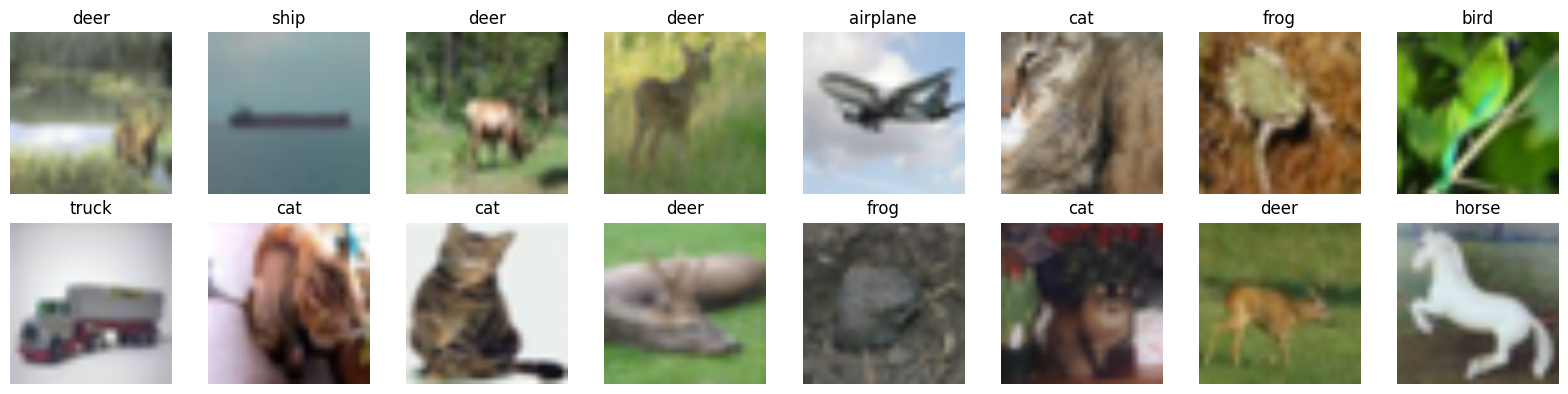

In [5]:
full_train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
full_train_size = len(full_train_ds)
val_size = int(full_train_size * 0.02)

train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [full_train_size - val_size, val_size])
overfit_train_ds, overfit_val_ds, _ = torch.utils.data.random_split(full_train_ds, [16, 16, full_train_size - 32])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)

overfit_train_loader = DataLoader(overfit_train_ds, batch_size=128, shuffle=False, num_workers=0)
overfit_val_loader = DataLoader(overfit_val_ds, batch_size=128, shuffle=False, num_workers=0)

classnames = full_train_ds.classes
num_classes = len(classnames)

print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

In [6]:
class HardcodedPrompt(nn.Module):
    def __init__(self, clip, classnames):
        super().__init__()
        text_tower = getattr(clip, "text", clip)
        prompts = [f"a photo of a {c}" for c in classnames]
        text_tokens = tokenizer(prompts)
        text_features = text_tower.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward_text_features(self):
        return self.text_features

In [7]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, clip, hardcoded_prompt):
        super().__init__()
        self.clip = clip
        self.hardcoded_prompt = hardcoded_prompt

    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = self.hardcoded_prompt.forward_text_features()
            logits = 100.0 * image_features @ text_features.T
        return logits

In [8]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip, tokenizer, classnames, n_ctx=16, init_scale=0.02):
        super().__init__()
        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer
        self.classnames = classnames

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1] # 512

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Tokenize bare classnames (we'll prepend soft context ourselves)
        with torch.no_grad():
            self.register_buffer('class_token_ids', tokenizer(classnames)) # [C, L]
            # EOT trick: in CLIP tokenization the EOT id is the largest id in each row
            self.register_buffer('eot_indices', self.class_token_ids.argmax(dim=-1))

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.clip.parameters():
            p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.text_tower.train()
        else:
          self.clip.eval()
          self.text_tower.eval()

    def forward_text_features(self):
        C = len(self.classnames)
        token_ids = self.class_token_ids  # [C, L]

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(token_ids)  # [C, L, W]

        sos = tok_emb[:, :1, :]         # [C,1,W]
        class_part = tok_emb[:, 1:, :]  # [C,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(C, -1, -1)  # [C, n_ctx, W]

        # [SOS] + [CTX...CTX] + [class tokens...]
        x = torch.cat([sos, ctx, class_part], dim=1)  # [C, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = x.new_zeros(C, pad_len, x.size(2))
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot = (self.eot_indices + self.ctx.shape[0]).clamp(max=L - 1)
        text_emb = x[torch.arange(C, device=eot.device), eot] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

In [10]:
class CoOpClip(nn.Module):
    def __init__(self, clip, coop_prompt):
        super().__init__()
        self.clip = clip
        self.coop_prompt = coop_prompt

        self.clip.requires_grad_(False)
        self.coop_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.coop_prompt.train()
        else:
          self.clip.eval()
          self.coop_prompt.eval()

    def forward(self, images):
        images = images.to(device)
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = self.coop_prompt.forward_text_features()
        logits = 100.0 * image_features @ text_features.T
        return logits

In [14]:
def accuracy(logits, labels):
    preds = logits.argmax(dim=-1)
    correct = (preds == labels).float().mean().item()
    return correct

In [15]:
@torch.no_grad()
def evaluate_classifier(model, test_loader, loss_fn, device, desc="eval", pbar=True):
  model.eval()
  loss_sum, correct, count = 0.0, 0, 0
  iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
  for images, labels in iterator:
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    logits = model(images)
    loss = loss_fn(logits, labels)

    bs = labels.size(0)
    loss_sum += loss.item() * bs
    preds = logits.argmax(dim=1)
    correct += (preds == labels).sum().item()
    count += bs

    if pbar:
      acc = (correct / max(1, count)) * 100.0
      iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

  avg_loss = loss_sum / max(1, count)
  avg_acc = correct / max(1, count)
  return avg_loss, avg_acc

def train(
    model, train_loader, val_loader, device="cpu",
    epochs=5, batch_size=256, lr=5e-3, log_train_interval=25, log_val_interval=None
):
    model.to(device)

    print(model.coop_prompt.parameters())
    optimizer = torch.optim.AdamW([model.coop_prompt.ctx], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_time': [], 'val_time': []
    }

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = evaluate_classifier(
            model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history['val_time'].append(t)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images)
            loss = loss_fn(logits, labels)
            acc = accuracy(logits, labels)

            history['train_time'].append(t)
            history['train_loss'].append(loss.item())
            history['train_acc'].append(acc)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

            if log_val_interval and t % log_val_interval == 0:
                val_loss, val_acc = evaluate_classifier(
                     model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_time'].append(t)
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

        avg_train_loss = np.mean(history['train_loss'][-len(train_loader):])
        avg_train_acc = np.mean(history['train_acc'][-len(train_loader):])
        avg_val_loss = history['val_loss'][-1]
        avg_val_acc = history['val_acc'][-1]

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return history

In [16]:
coop_prompt = CoOpPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    classnames=classnames,
    n_ctx=cfg.prompt_len,
)

coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=coop_prompt,
).to(device)

loss, acc = evaluate_classifier(
    model=coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy before training: {acc}")

history = train(
    model=coopclip_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=25,
    log_val_interval=25
)

Testing CoOpClip on full val:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy before training: 0.947
<generator object Module.parameters at 0x79307c673d80>


valid:   0%|          | 0/8 [00:00<?, ?it/s]

Before training: val_loss=0.1606  val_acc=94.70%


Epoch 1/1 | train:   0%|          | 0/383 [00:00<?, ?it/s]

Epoch 001: train_loss=0.1239  train_acc=95.83%  val_loss=0.0830  val_acc=97.30%


In [28]:
loss, acc = evaluate_classifier(
    model=coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
print(f"Accuracy after training: {acc}")

Testing trained CoOpClip on full val:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy after training: 0.969


In [17]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # --- Loss (left) ---
    ax = axes[0]
    ax.plot(history['train_time'], history['train_loss'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_loss' in history and len(history['val_time']) and len(history['val_loss']):
        ax.plot(history['val_time'], history['val_loss'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Loss'); ax.set_title('Loss'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    # --- Accuracy (right) ---
    ax = axes[1]
    if 'train_acc' in history and len(history['train_acc']):
        ax.plot(history['train_time'], history['train_acc'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_acc' in history and len(history['val_time']) and len(history['val_acc']):
        ax.plot(history['val_time'], history['val_acc'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Accuracy'); ax.set_title('Accuracy'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    plt.show()

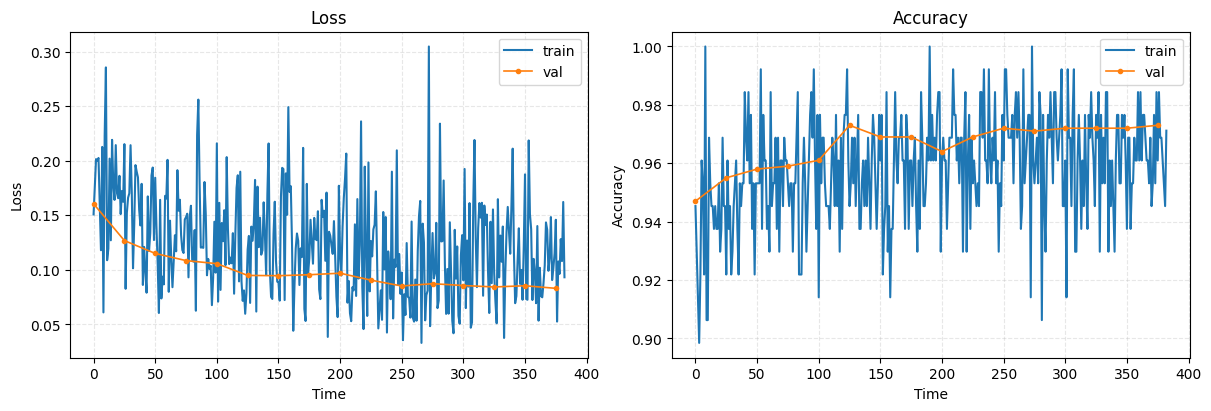

In [18]:
plot_history(history)

In [ ]:
overfit_coop_prompt = CoOpPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    classnames=classnames,
    n_ctx=cfg.prompt_len,
)

overfit_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=overfit_coop_prompt,
).to(device)

history = train(
    model=overfit_coopclip_model,
    train_loader=overfit_train_loader,
    val_loader=overfit_val_loader,
    device=device,
    epochs=cfg.overfit_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=1,
    log_val_interval=1
)

loss, acc = evaluate_classifier(
    model=overfit_coopclip_model,
    test_loader=overfit_val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing Overfitted CoOpClip on overfit val loader",
    pbar=True
)

In [ ]:
plot_history(history)

In [19]:
import torch, hashlib, json

def save_coop_prompt(coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str, classnames: list, n_ctx: int):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    payload = {
        "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
        "meta": {
            "model_name": model_name,
            "pretrained": pretrained,
            "n_ctx": int(n_ctx),
            "classnames": list(classnames),
            # quick fingerprint to catch class order changes
            "classnames_sha1": hashlib.sha1(
                json.dumps(list(classnames), ensure_ascii=False).encode("utf-8")
            ).hexdigest(),
        }
    }
    torch.save(payload, path)


In [20]:
save_coop_prompt(coopclip_model.coop_prompt, "s0_coop_cifar10.pt",
                 model_name=cfg.model_name, pretrained=cfg.pretrained,
                 classnames=classnames, n_ctx=cfg.prompt_len)

In [47]:
def load_coop_prompt(clip: nn.Module, tokenizer, path: str):
  payload = torch.load(path)
  ctx = payload["ctx"]
  n_ctx = payload["meta"]["n_ctx"]
  classnames = payload["meta"]["classnames"]
  model_name = payload["meta"]["model_name"]
  if cfg.model_name != model_name:
    raise ValueError(f"Model from path: '{model_name}' doesn't match the cfg.modelname: '{cfg.model_name}'")
  coop_prompt = CoOpPrompt(clip, tokenizer, classnames, n_ctx)
  with torch.no_grad():
    coop_prompt.ctx.copy_(ctx)

  return coop_prompt

In [48]:
loaded_prompt = load_coop_prompt(clip_model, tokenizer, "s0_coop_cifar10.pt")

In [27]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=loaded_prompt,
).to(device)

loss, acc = evaluate_classifier(
    model=loaded_coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for loaded model: {acc}")

Testing CoOpClip on full val:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy for loaded model: 0.969


In [ ]:
from PIL import Image
image = Image.open("fluffy_dog.jpg")
plt.imshow(image)
logits = coopclip_model(preprocess(image).unsqueeze(0))
pred = logits.argmax(1)
pred_class = classnames[pred]
print(f"The image is a {pred_class}")

In [ ]:
#coop, history = train_coop(
#    model=model,
#    tokenizer=tokenizer,
#    classnames=classnames,
#    train_loader=train_loader,
#    val_loader=val_loader,
#    device=device,
#    n_ctx=cfg.prompt_len,
#    epochs=cfg.max_epochs,
#    batch_size=cfg.batch_size,
#    lr=cfg.lr_prompt,
#    num_workers=cfg.num_workers,
#)

In [ ]:
# 10) Extra analysis: (optional) confusion matrix if sklearn is available
try:
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, leave=False, desc='cm'):
            p = coopclip_model(x.to(device)).argmax(dim=1).cpu()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(p.tolist())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classnames)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, include_values=False, xticks_rotation=90, cmap='Blues')
    plt.title('Confusion Matrix (test)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Install scikit-learn to see confusion matrix. Skipping. Error:', e)